## Load, process, analyse 

In [296]:
import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt

### Load dataset  and look at basic info

In [297]:
dataframe = pd.read_csv('Testovoe_zadanie_dataframe.csv',sep=';',encoding='cp1251')
print(dataframe.head(10),'\n')
total_rows = dataframe.shape[0]
not_null_rows = dataframe['Что-то'].notnull().sum()

print('Total rows: ',total_rows)
print('Not null rows: ',not_null_rows)
print('Null percentage',1 - not_null_rows/total_rows)

data = dataframe['Что-то']
timestamp = dataframe['Time']

print('data range: from', timestamp[0], ' to ',timestamp.iloc[-1])
data.describe()

               Time  Что-то
0  27.07.2022 15:15   718.0
1  27.07.2022 15:30   665.0
2  27.07.2022 15:45   637.0
3  27.07.2022 16:00   661.0
4  27.07.2022 16:15   668.0
5  27.07.2022 16:30   687.0
6  27.07.2022 16:45   692.0
7  27.07.2022 17:00   640.0
8  27.07.2022 17:15   680.0
9  27.07.2022 17:30   678.0 

Total rows:  2881
Not null rows:  2718
Null percentage 0.05657757723012846
data range: from 27.07.2022 15:15  to  26.08.2022 15:15


count    2718.000000
mean      368.701619
std       295.226746
min         0.000000
25%        61.000000
50%       348.000000
75%       668.000000
max       982.000000
Name: Что-то, dtype: float64

* 5 percent of null values - not so much

### Fill NA values + convert to datetime

In [298]:
#pad vs backfill
dataframe.fillna(method="pad",inplace=True)

dataframe.index = pd.to_datetime(dataframe['Time'], errors='coerce', format='%d.%m.%Y %H:%M')
dataframe.drop(columns=['Time'],inplace=True)
assert dataframe.shape == (2881, 1), 'Error, shape of timeseries changed'

### Plotting

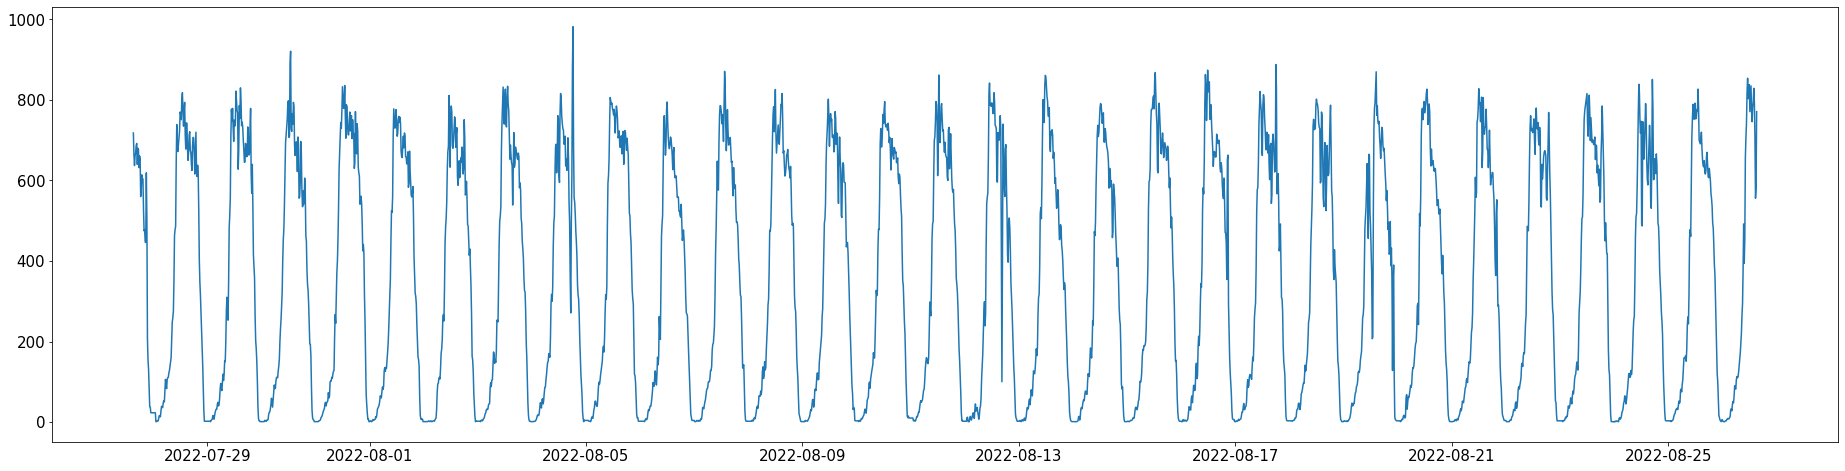

In [299]:
f = plt.figure()
f.set_size_inches(32,8)
plt.plot(dataframe.index,data) # x asis change

* looks like sine/cosine function with some noise

#### Time series decompasition   

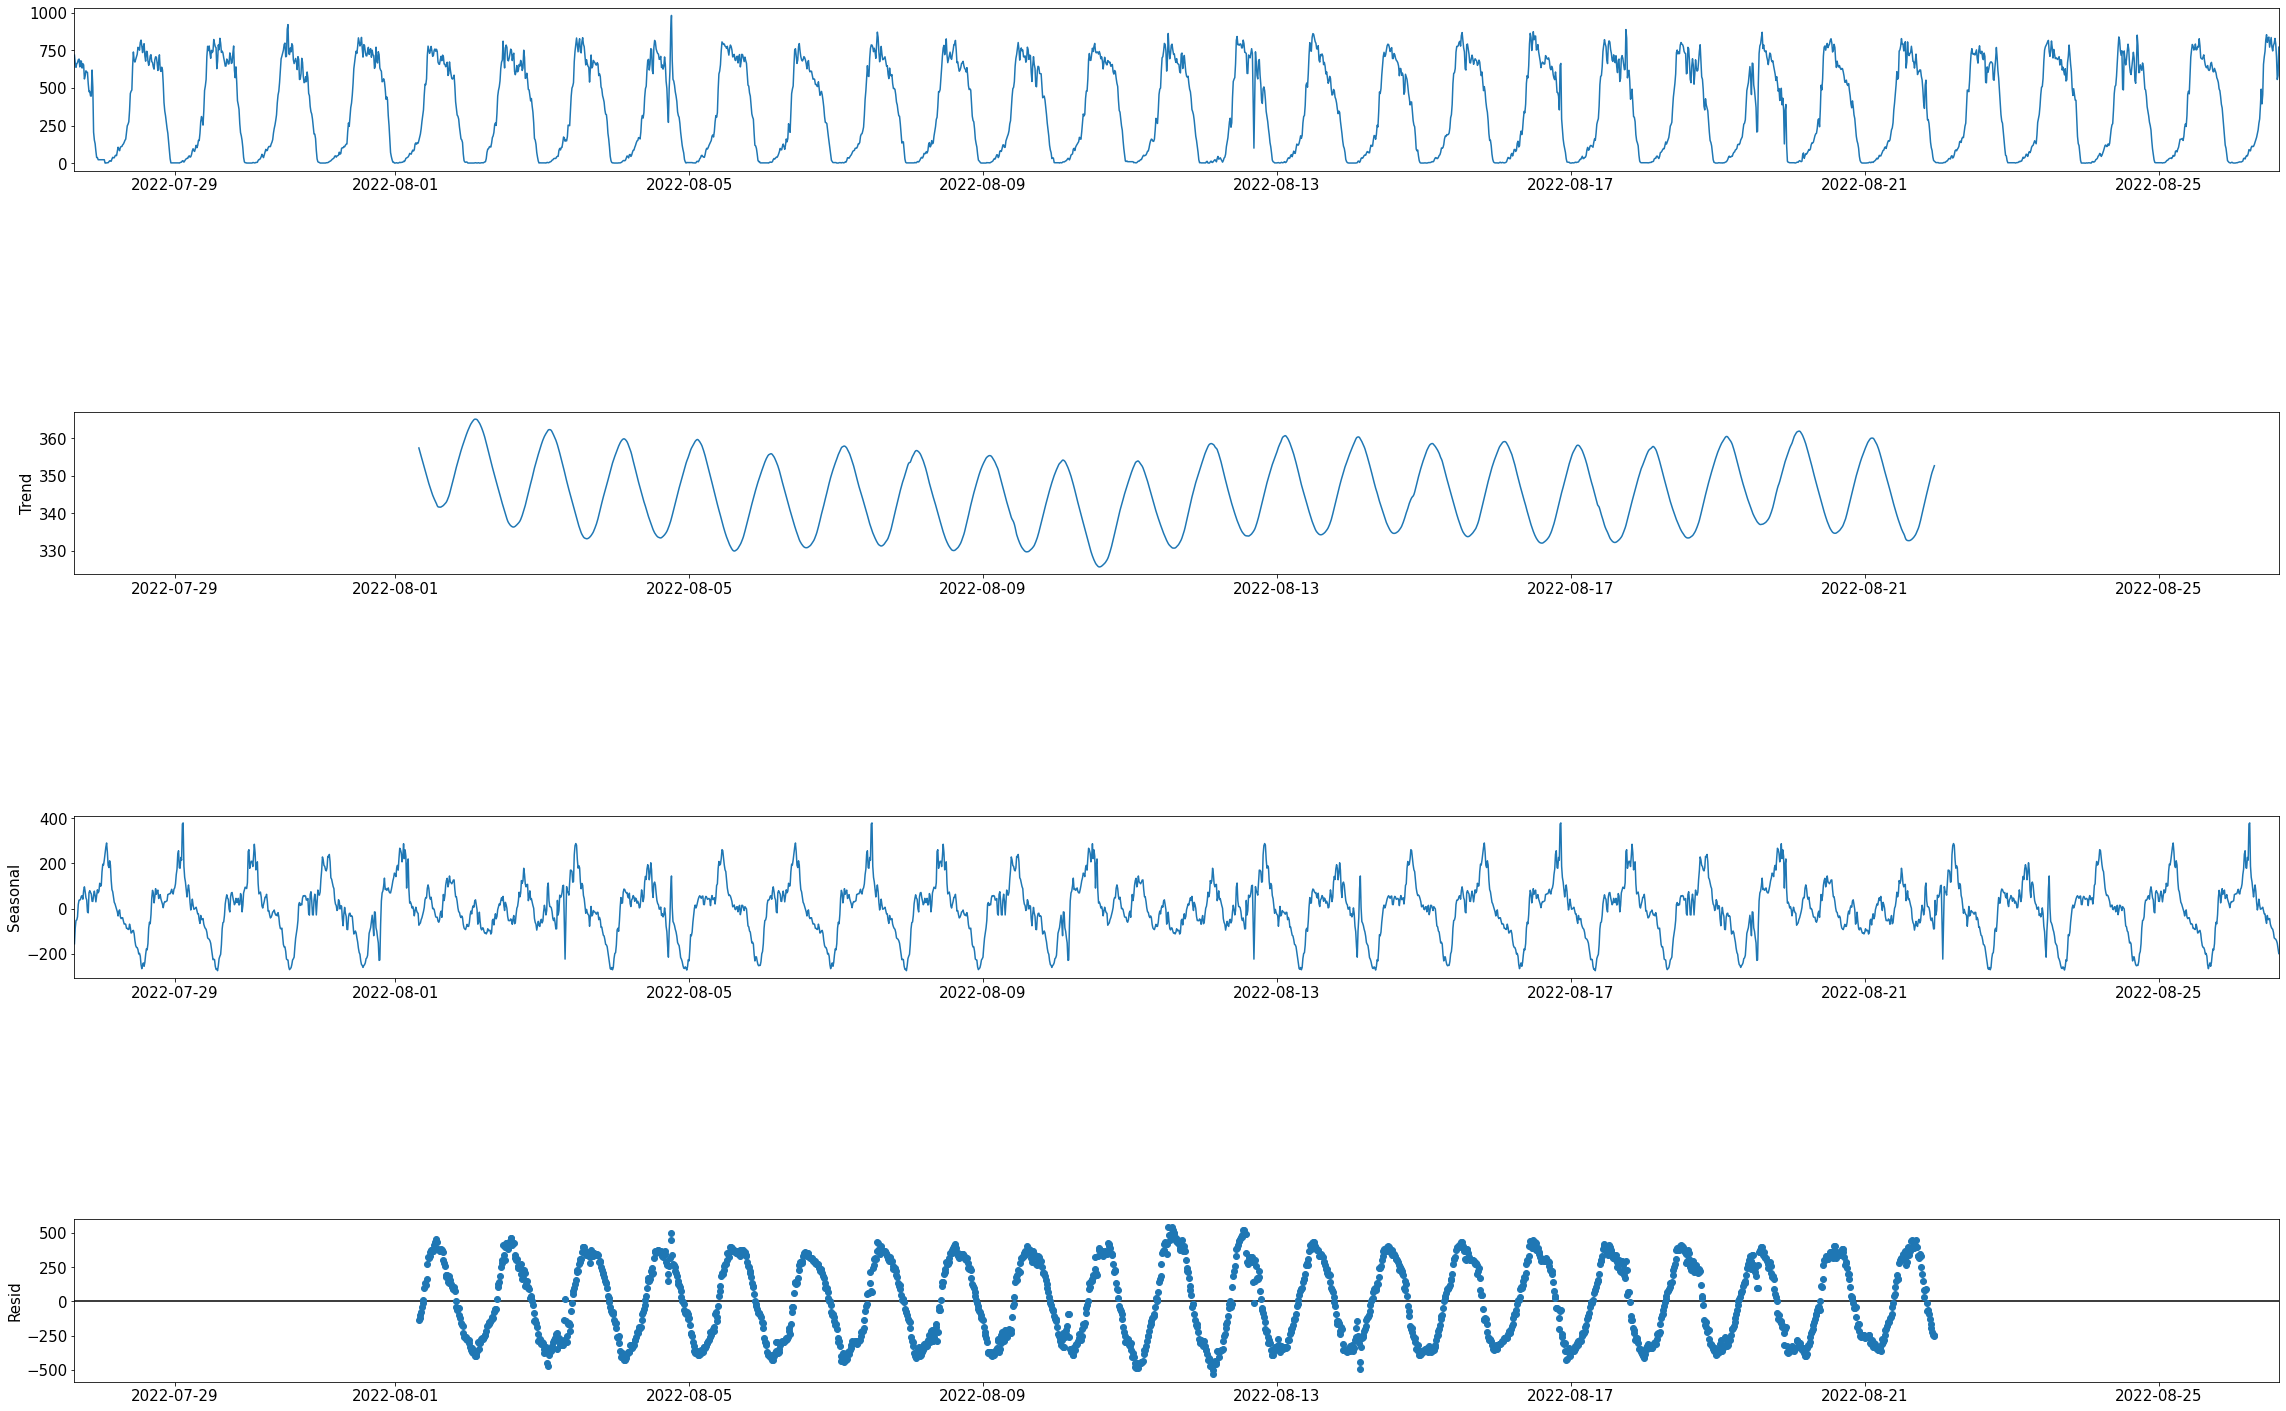

In [300]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(dataframe,period = 60*15)

fig = result.plot()
fig.set_size_inches(32,24)
plt.show()

* residual function looks like sine, could be aprocimated quite good  
Idea:
  * aprocimate residual
  * check quality (RMSE, MAPE)
  * decide that 5th percentile of absolute difference between fitted and real residual is anomaly

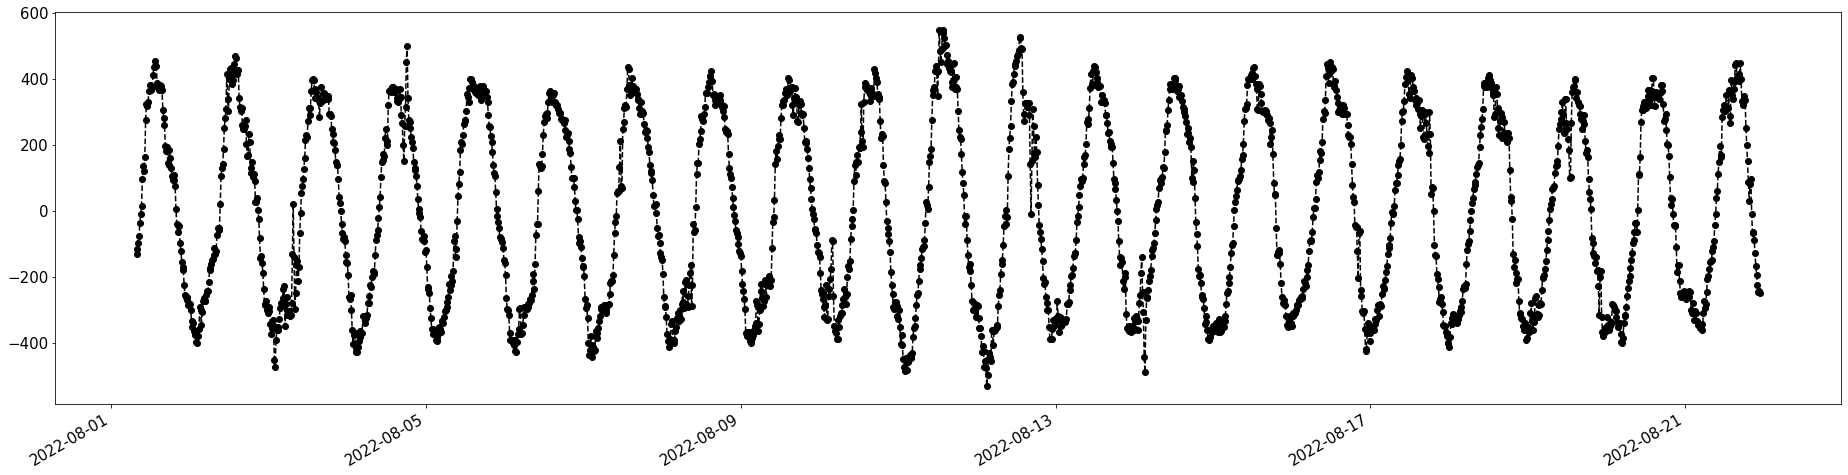

In [301]:
plt.rc('figure',figsize=(32,8))
plt.rc('font',size=15)
fig, ax = plt.subplots()
x_data = result.resid.index
y_data = result.resid.values
ax.plot_date(x_data, y_data, color='black',linestyle='--')
fig.autofmt_xdate()
plt.show()

* non-zero values percentage in residual:  

In [302]:
np.count_nonzero(~np.isnan(y_data))/len(y_data)

#remove all tailing nulls:
y_data = pd.Series(y_data)
last_valid = y_data[y_data.notnull()].index[-1]
y_curr = y_data.iloc[0:last_valid]

#remove all leading nulls:
first_valid = y_curr[y_curr.notnull()].index[0]
y_curr = y_curr.iloc[first_valid:]
y_curr.head()
print(y_curr.index[0])
print(y_curr)
print(y_curr.index[-1])
resid_df = pd.DataFrame()
resid_df.index = x_data[y_curr.index[0]:y_curr.index[-1] + 1]
resid_df['data'] = y_curr.values

450
450    -132.680074
451    -116.938222
452     -98.220630
453     -77.499889
454     -37.119704
           ...    
2425   -166.631185
2426   -194.104704
2427   -225.499889
2428   -245.792667
2429   -243.717667
Length: 1980, dtype: float64
2429


In [303]:
np.count_nonzero(~np.isnan(resid_df['data']))/len(resid_df['data'])

1.0

### Normalization of residual!!  

In [304]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(resid_df[['data']])
print('Min: %f, Max: %f' % (scaler.data_min_, scaler.data_max_))

y_normalized = scaler.transform(resid_df[['data']])

Min: -532.329889, Max: 546.470667


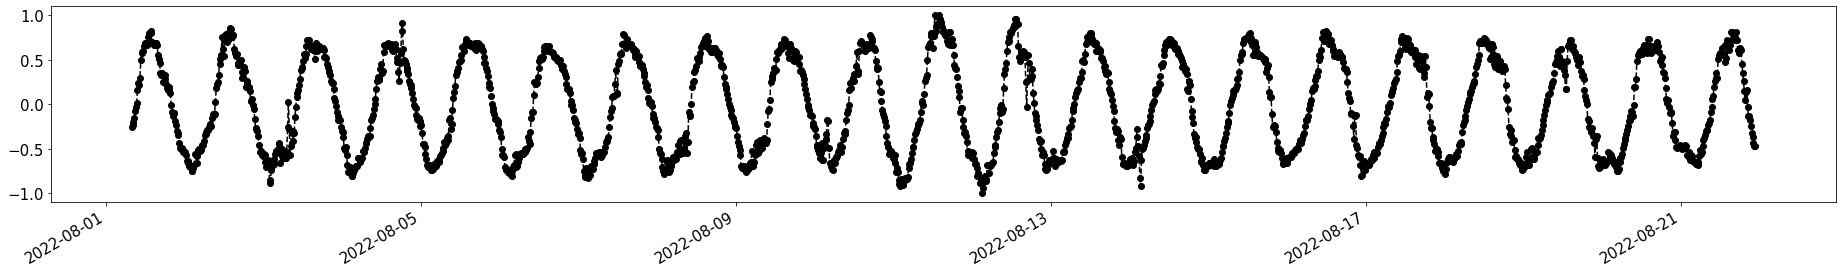

In [305]:
plt.rc('figure',figsize=(32,4))
plt.rc('font',size=15)
fig, ax = plt.subplots()
x_data = resid_df.index
y_data = y_normalized
ax.plot_date(x_data, y_data, color='black',linestyle='--')
fig.autofmt_xdate()
plt.show()

In [306]:
resid_df['data'] = y_normalized

### Train-test split  

In [307]:
TEST_PERCENTAGE = 0.2
test_size = int(TEST_PERCENTAGE * len(resid_df))
df_train = resid_df[:-test_size]
df_test = resid_df[-test_size:]

## Trying different models

### 1. Least squares fitting with scipy

In [308]:
from scipy import optimize
#guessed func
x_fit = np.linspace(0,100,len(df_train['data']))

def guessed_func(x, dist, amp, omega, phi):
    return dist + amp * np.cos(omega * x + phi)

params, params_covariance = optimize.curve_fit(guessed_func, x_fit, df_train['data'])

In [309]:
from IPython.display import display, Math
print('Fitted parameters:')
display(Math('a_0={:.2f}, a_1={:.2f}, \\omega={:.2f}, \\phi={:.2f}'.format(*params)))

Fitted parameters:


<IPython.core.display.Math object>

In [310]:
def comparing_plot(x, y_true, y_fitted):
    plt.plot(x, y_true, '*', label='Real data')
    plt.plot(x, y_fitted, '*', label='Fittted data')
    plt.legend()
    plt.show()

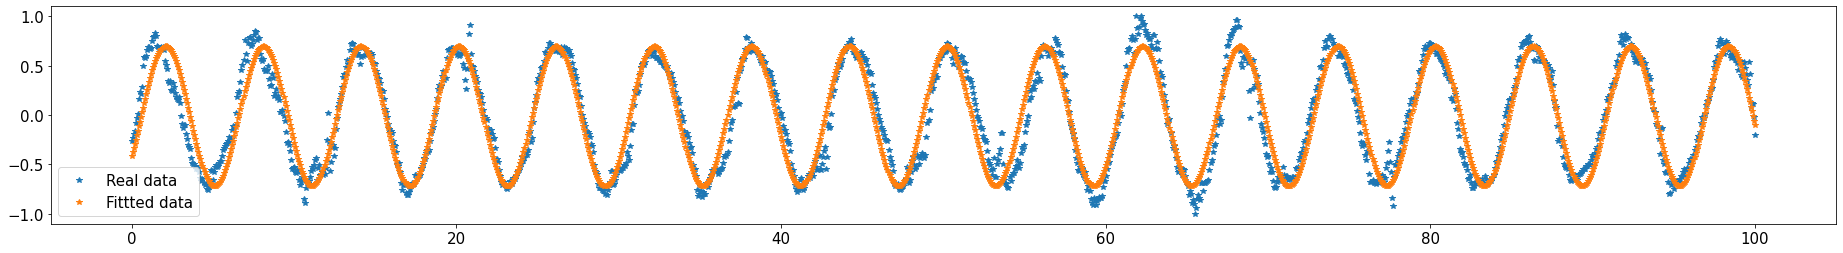

In [311]:
y_fit = [guessed_func(x_curr, *params) for x_curr in x_fit]
comparing_plot(x=x_fit, y_true=df_train['data'], y_fitted=y_fit)

#### Testing:

In [312]:
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error

def test_model(y_train,y_predicted,y_test, params,return_result=True): 
    print('train error')
    #scale data back:
    y_true = scaler.inverse_transform([y_train])
    y_pred = scaler.inverse_transform([y_predicted])
    print("RMSE = ", mean_squared_error(y_true[0],y_pred[0],squared=False))
    print("MAPE = ", mean_absolute_percentage_error(y_true[0],y_pred[0]))
    comparing_plot(x_fit, y_true[0], y_pred[0])

    #Testing:
    print('test error:')

    # because x should be scaled proportional to dataframe size
    x_test_fit = np.linspace(100,100//(1-TEST_PERCENTAGE),len(y_test),endpoint=False)
    y_test_fit = [guessed_func(x_curr, *params) for x_curr in x_test_fit]

    y_true_test = scaler.inverse_transform([y_test])
    y_pred_test = scaler.inverse_transform([y_test_fit])
    print("RMSE = ", mean_squared_error(y_true_test[0],y_pred_test[0],squared=False))
    print("MAPE = ", mean_absolute_percentage_error(y_true_test[0],y_pred_test[0]))
    comparing_plot(x_test_fit, y_true_test[0], y_pred_test[0])
    
    if(return_result):
        diff = abs(np.concatenate([y_true[0],y_true_test[0]]) - np.concatenate([y_pred[0],y_pred_test[0]]))
        return diff

train error
RMSE =  90.15874022278818
MAPE =  1.0287873299071


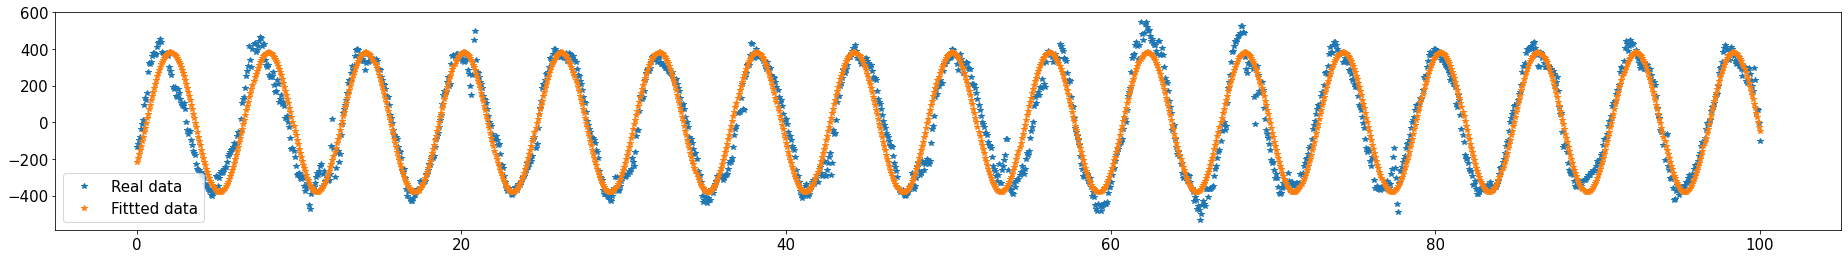

test error:
RMSE =  100.15377770374735
MAPE =  1.1211458170952469


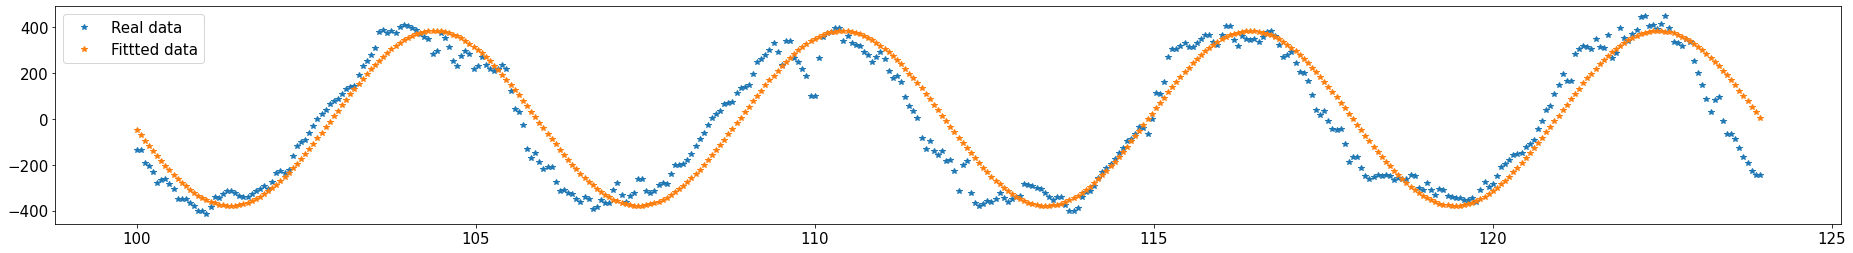

In [313]:
diff = test_model(df_train['data'],y_fit,df_test['data'],params)

#### Guessed as anomaly:

In [314]:
def detected_anomalies(error:np.array)->pd.DataFrame:
    treshold_value = pd.Series(error).quantile(0.99)
    anomaly_idicies = np.argwhere(error > treshold_value).reshape(-1)
    return dataframe.iloc[anomaly_idicies.tolist()]   

In [315]:
anomaly_idicies_scipy = detected_anomalies(diff)
anomaly_idicies_scipy

,Что-то
Time,
2022-07-27 18:15:00,653.0
2022-07-28 18:45:00,673.0
2022-08-03 16:30:00,642.0
2022-08-03 16:45:00,683.0
2022-08-04 16:30:00,545.0
2022-08-04 16:45:00,497.0
2022-08-05 11:15:00,789.0
2022-08-05 11:30:00,792.0
2022-08-05 15:30:00,707.0


### 2. Hyperopt

In [336]:
def objective(a0, a1, w, f):
    """Objective function to minimize"""
    return np.mean((a0+ a1 * np.cos(w*x_fit + f) - df_train['data'])**2)

def objective2(args):
    return objective(*args)
from hyperopt import hp, tpe, Trials, fmin
from IPython.display import display, Math

space = [hp.uniform('a0', -0.1, 0.1),
         hp.uniform('a1', 0.6, 0.8), 
         hp.uniform('w', 0, np.pi), 
         hp.uniform('f', -np.pi, np.pi)]

tpe_algo = tpe.suggest
tpe_trials = Trials()

tpe_best = fmin(fn=objective2, space=space, algo=tpe_algo, trials=tpe_trials, max_evals=500, rstate=np.random.default_rng(0))

print('Fitted parameters:')
display(Math('a_0={a0:.2f}, a_1={a1:.2f}, \\omega={w:.2f}, \\phi={f:.2f}'.format(**tpe_best)))


100%|██████████| 500/500 [00:12<00:00, 40.55trial/s, best loss: 0.051929466740085174]
Fitted parameters:


<IPython.core.display.Math object>

In [337]:
best_params = list(tpe_best.values())
#resolving w and phi mixup
best_params[2] = list(tpe_best.values())[3]
best_params[3] = list(tpe_best.values())[2]

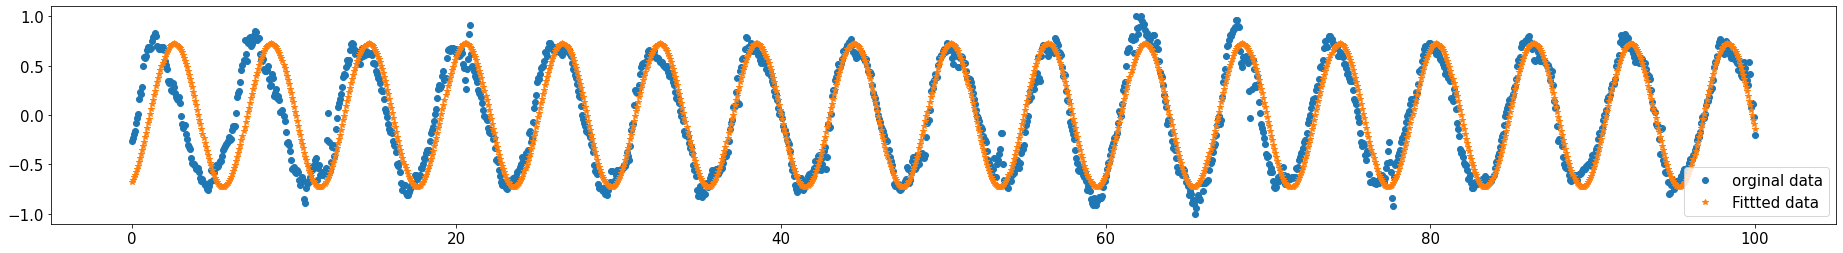

In [338]:
y_fit = [guessed_func(x_curr, *best_params) for x_curr in x_fit]
plt.plot(x_fit, df_train['data'], 'o', label='orginal data')
plt.plot(x_fit, y_fit, '*', label='Fittted data')
plt.legend()
plt.show()

#### Testing:

train error
RMSE =  122.91873926746685
MAPE =  1.2467394368170712


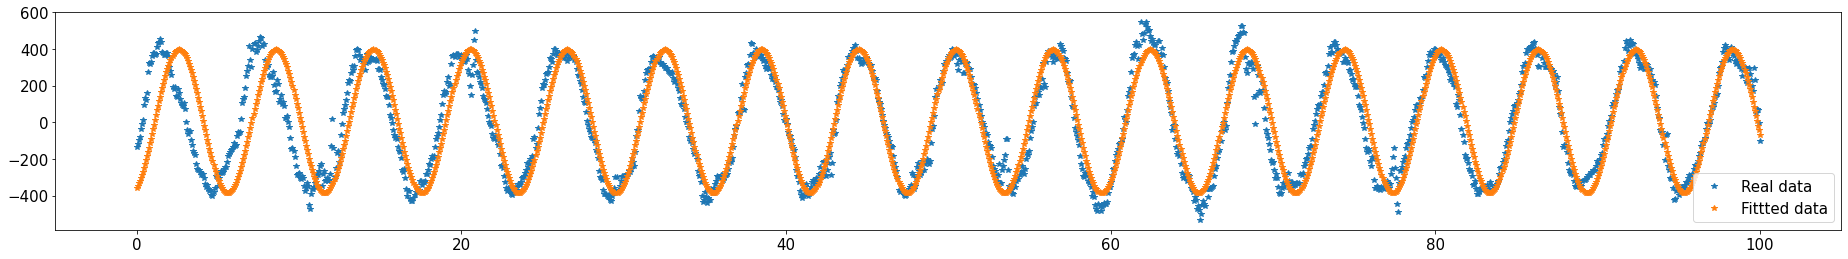

test error:
RMSE =  75.71879976498285
MAPE =  1.2881632237777327


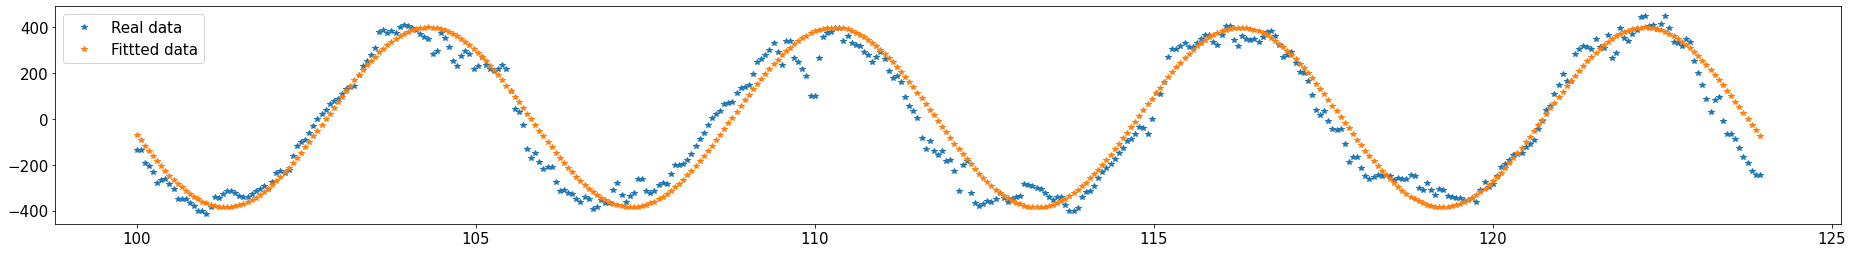

In [339]:
diff = test_model(df_train['data'],y_fit,df_test['data'],best_params)

#### Guessed as anomaly  

In [320]:
anomaly_hyperopt = detected_anomalies(diff)
anomaly_hyperopt

,Что-то
Time,
2022-07-27 18:00:00,661.0
2022-07-27 18:15:00,653.0
2022-07-27 18:30:00,560.0
2022-07-27 18:45:00,580.0
2022-07-27 19:00:00,614.0
2022-07-27 19:15:00,604.0
2022-07-27 19:30:00,604.0
2022-07-28 03:30:00,28.0
2022-07-28 03:45:00,39.0


### 3. Classification and Regression Trees (CART)

In [341]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

outliers_fraction = float(.01)
scaler = StandardScaler()
np_scaled = scaler.fit_transform(dataframe['Что-то'].values.reshape(-1, 1))
data = pd.DataFrame(np_scaled)
# train isolation forest
model =  IsolationForest(contamination=outliers_fraction)
model.fit(data)

IsolationForest(contamination=0.01)

#### Results

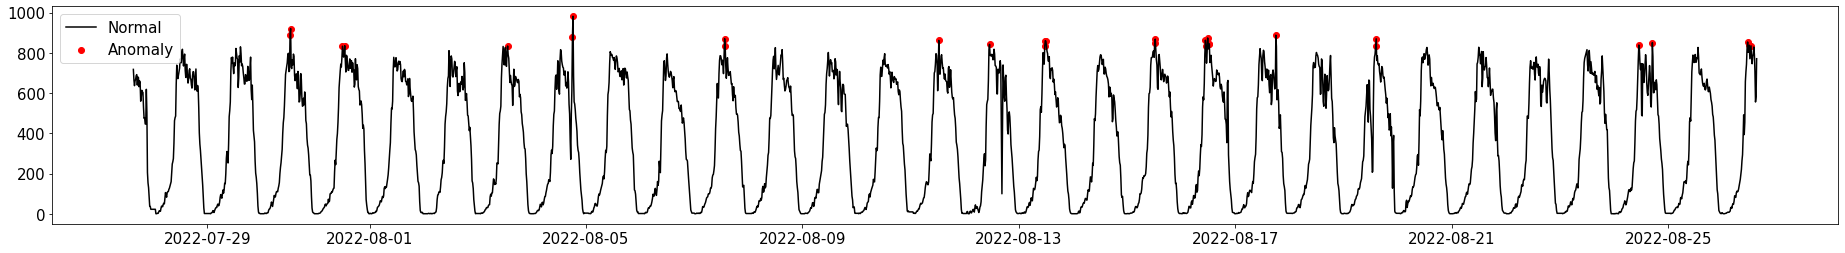

In [344]:
dataframe['anomaly'] = model.predict(data)
# visualization
fig, ax = plt.subplots(figsize=(32,4))
a = dataframe.loc[dataframe['anomaly'] == -1, ['Что-то']] #anomaly
ax.plot(dataframe.index, dataframe['Что-то'], color='black', label = 'Normal')
ax.scatter(a.index,a['Что-то'], color='red', label = 'Anomaly')
plt.legend()
plt.show()

In [351]:
a

,Что-то
Time,
2022-07-30 12:45:00,891.0
2022-07-30 13:00:00,921.0
2022-07-31 12:00:00,833.0
2022-07-31 13:00:00,836.0
2022-08-03 13:15:00,834.0
2022-08-04 18:00:00,877.0
2022-08-04 18:15:00,982.0
2022-08-07 13:30:00,871.0
2022-08-07 13:45:00,836.0
